In [1]:
import numpy as np
import keras as K
import matplotlib.pyplot as plt
from itertools import product
#import torch

Using TensorFlow backend.


# N-Net with Adverserial Sub-Nets

We'll use MNIST as an example, but this should generalize

## Data Pre-Processing

In [2]:
(x_train, y_train), (x_test, y_test) = K.datasets.mnist.load_data()

In [3]:
IMAGE_SHAPE = x_train.shape[1:]

Scale from 255 grayscale to `[0,1]`

In [4]:
x_train, x_test  = x_train/255.0, x_test/255.0

Convert labels to one-hot representation

In [5]:
y_train_oh = K.utils.to_categorical(y_train, 10)

In [6]:
y_test_oh = K.utils.to_categorical(y_test, 10)

## Image Plotting Function

In [7]:
def plot_image(d, l):
    print("Label {}".format(l))
    plt.figure(figsize=(2,2))
    plt.imshow(d.reshape(IMAGE_SHAPE)*255, cmap='gray')

In [8]:
def printer(n, test=False):
    if test:
        plot_image(x_test[n], y_test[n])
    else:
        plot_image(x_train[n], y_train[n])
    plt.show()

Label 4


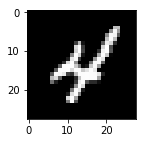

In [9]:
printer(9)

## Network Structure

Input Layers are Standard, a batch input and flatten the 2d images

In [10]:
in_layer = K.layers.Input(shape=IMAGE_SHAPE, name='Input')

In [11]:
flatten = K.layers.Flatten()(in_layer)

The hidden layer is a set of individual dense layers. Sigmoid allows for easier calculation of loss later

In [12]:
MODULE_SIZE = 9

In [13]:
N_MODULES = 20

In [14]:
def get_layer(n):
    return (K.layers.Dense(MODULE_SIZE, name='Mod_'+str(n)+'r', activation='relu'), 
            K.layers.Dense(MODULE_SIZE, name='Mod_'+str(n)+'s', activation='sigmoid'))

In [15]:
modules = [get_layer(i) for i in range(N_MODULES)]

In [16]:
mod_out = [i[1](i[0](flatten)) for i in modules]

Then these layers are concatenated before input into the output layer

In [17]:
concat = K.layers.Concatenate(name='Concatenate')(mod_out)

In [18]:
output = K.layers.Dense(10, name='Output', activation='softmax')(concat)

Since we are using a custom loss we'll also manually add an input layer

In [19]:
label_in = K.layers.Input((10,))

The modules are paired according to some topology that will decide how we calculate the loss

In [20]:
# pairs = [(0,1), (0,2), (1,3), (2,3)]

In [21]:
pairs = [i for i in product(range(N_MODULES), range(N_MODULES)) if i[0]!=i[1]]

Several step here to generate the loss

In [22]:
# out_diff = [K.layers.Subtract()([mod_out[i], mod_out[j]]) for i, j in pairs]

In [23]:
# out_dot = [K.layers.Dot(1, normalize=True)([i, i]) for i in out_diff]

In [24]:
out_diff = [K.layers.Dot(1)([mod_out[i], mod_out[j]]) for i, j in pairs]

In [25]:
dot_sum = K.layers.Average()(out_diff)[:, 0]

This is loss is then combined with the cross entropy between the output and supplied labels

In [26]:
# loss = K.losses.categorical_crossentropy(output, label_in)-0.5*dot_sum

In [27]:
loss = K.losses.categorical_crossentropy(output, label_in)-0.5*dot_sum

Finally set the model. We'll output the hidden-layer outputs for later analysis

In [28]:
model = K.Model([in_layer, label_in], [output]+mod_out)

In [29]:
model.add_loss(loss)

In [30]:
import IPython

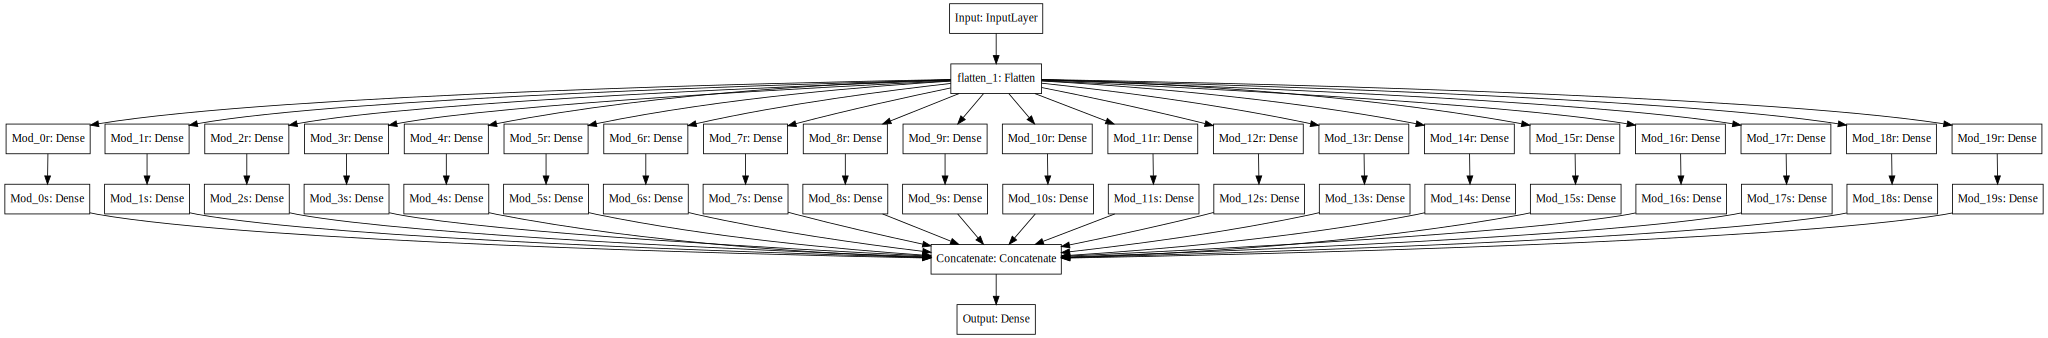

In [31]:
IPython.display.SVG(K.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [32]:
accuracy = K.metrics.categorical_accuracy(output, label_in)

In [33]:
model.compile(optimizer ='RMSprop', metrics=[accuracy]) 

In [34]:
h = model.fit([x_train, y_train_oh], epochs=150, validation_split=0.2, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/150
 - 54s - loss: 4.5268 - val_loss: 3.0739
Epoch 2/150
 - 47s - loss: 1.8883 - val_loss: 1.5430
Epoch 3/150
 - 47s - loss: 1.3394 - val_loss: 1.3276
Epoch 4/150
 - 47s - loss: 0.7625 - val_loss: 0.0906
Epoch 5/150
 - 47s - loss: -3.2411e-01 - val_loss: -1.1180e+00
Epoch 6/150
 - 48s - loss: -1.7333e+00 - val_loss: -2.7252e+00
Epoch 7/150
 - 48s - loss: -3.0432e+00 - val_loss: -3.1486e+00
Epoch 8/150
 - 47s - loss: -3.2462e+00 - val_loss: -3.2448e+00
Epoch 9/150
 - 48s - loss: -3.3511e+00 - val_loss: -3.3308e+00
Epoch 10/150
 - 49s - loss: -3.4241e+00 - val_loss: -3.3338e+00
Epoch 11/150
 - 47s - loss: -3.4805e+00 - val_loss: -3.4022e+00
Epoch 12/150
 - 47s - loss: -3.5224e+00 - val_loss: -3.4475e+00
Epoch 13/150
 - 48s - loss: -3.5642e+00 - val_loss: -3.4676e+00
Epoch 14/150
 - 48s - loss: -3.5982e+00 - val_loss: -3.4851e+00
Epoch 15/150
 - 48s - loss: -3.6186e+00 - val_loss: -3.5078e+00
Epoch 16/150
 - 47s - loss: -3.6490e+00

In [35]:
#plt.plot(np.log(h.history['loss']))
#plt.plot(np.log(h.history['val_loss']))
#plt.show();

In [36]:
res = model.predict([x_test, y_test_oh])

In [37]:
p = np.argmax(res[0], axis=1)

In [38]:
np.sum(p == y_test)/float(y_test.shape[0])

0.9365

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
cm = confusion_matrix(y_test, p)

In [41]:
cm

array([[ 952,    0,   10,    0,    0,    7,    5,    3,    3,    0],
       [   0, 1101,   10,    7,    0,    6,    3,    1,    7,    0],
       [   6,    1,  976,   10,    5,    3,    1,   11,   18,    1],
       [   1,    0,   14,  947,    0,   22,    0,   10,   15,    1],
       [   0,    3,   16,    0,  922,    8,    3,    4,    5,   21],
       [   8,    1,    5,   27,    5,  824,    3,    4,   10,    5],
       [   8,    0,   15,    2,    7,   17,  903,    1,    5,    0],
       [   1,    7,   17,    8,    5,    2,    0,  964,    4,   20],
       [   5,    1,   31,   29,    6,   23,    3,   16,  856,    4],
       [   6,    4,    8,   15,   22,    8,    0,   15,   11,  920]])

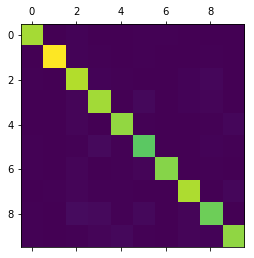

In [42]:
plt.matshow(cm);

In [43]:
W = np.stack([m[0].get_weights()[0] for m in modules])
W = (W-W.min())/(W.max()-W.min())

In [44]:
W.shape

(20, 784, 9)

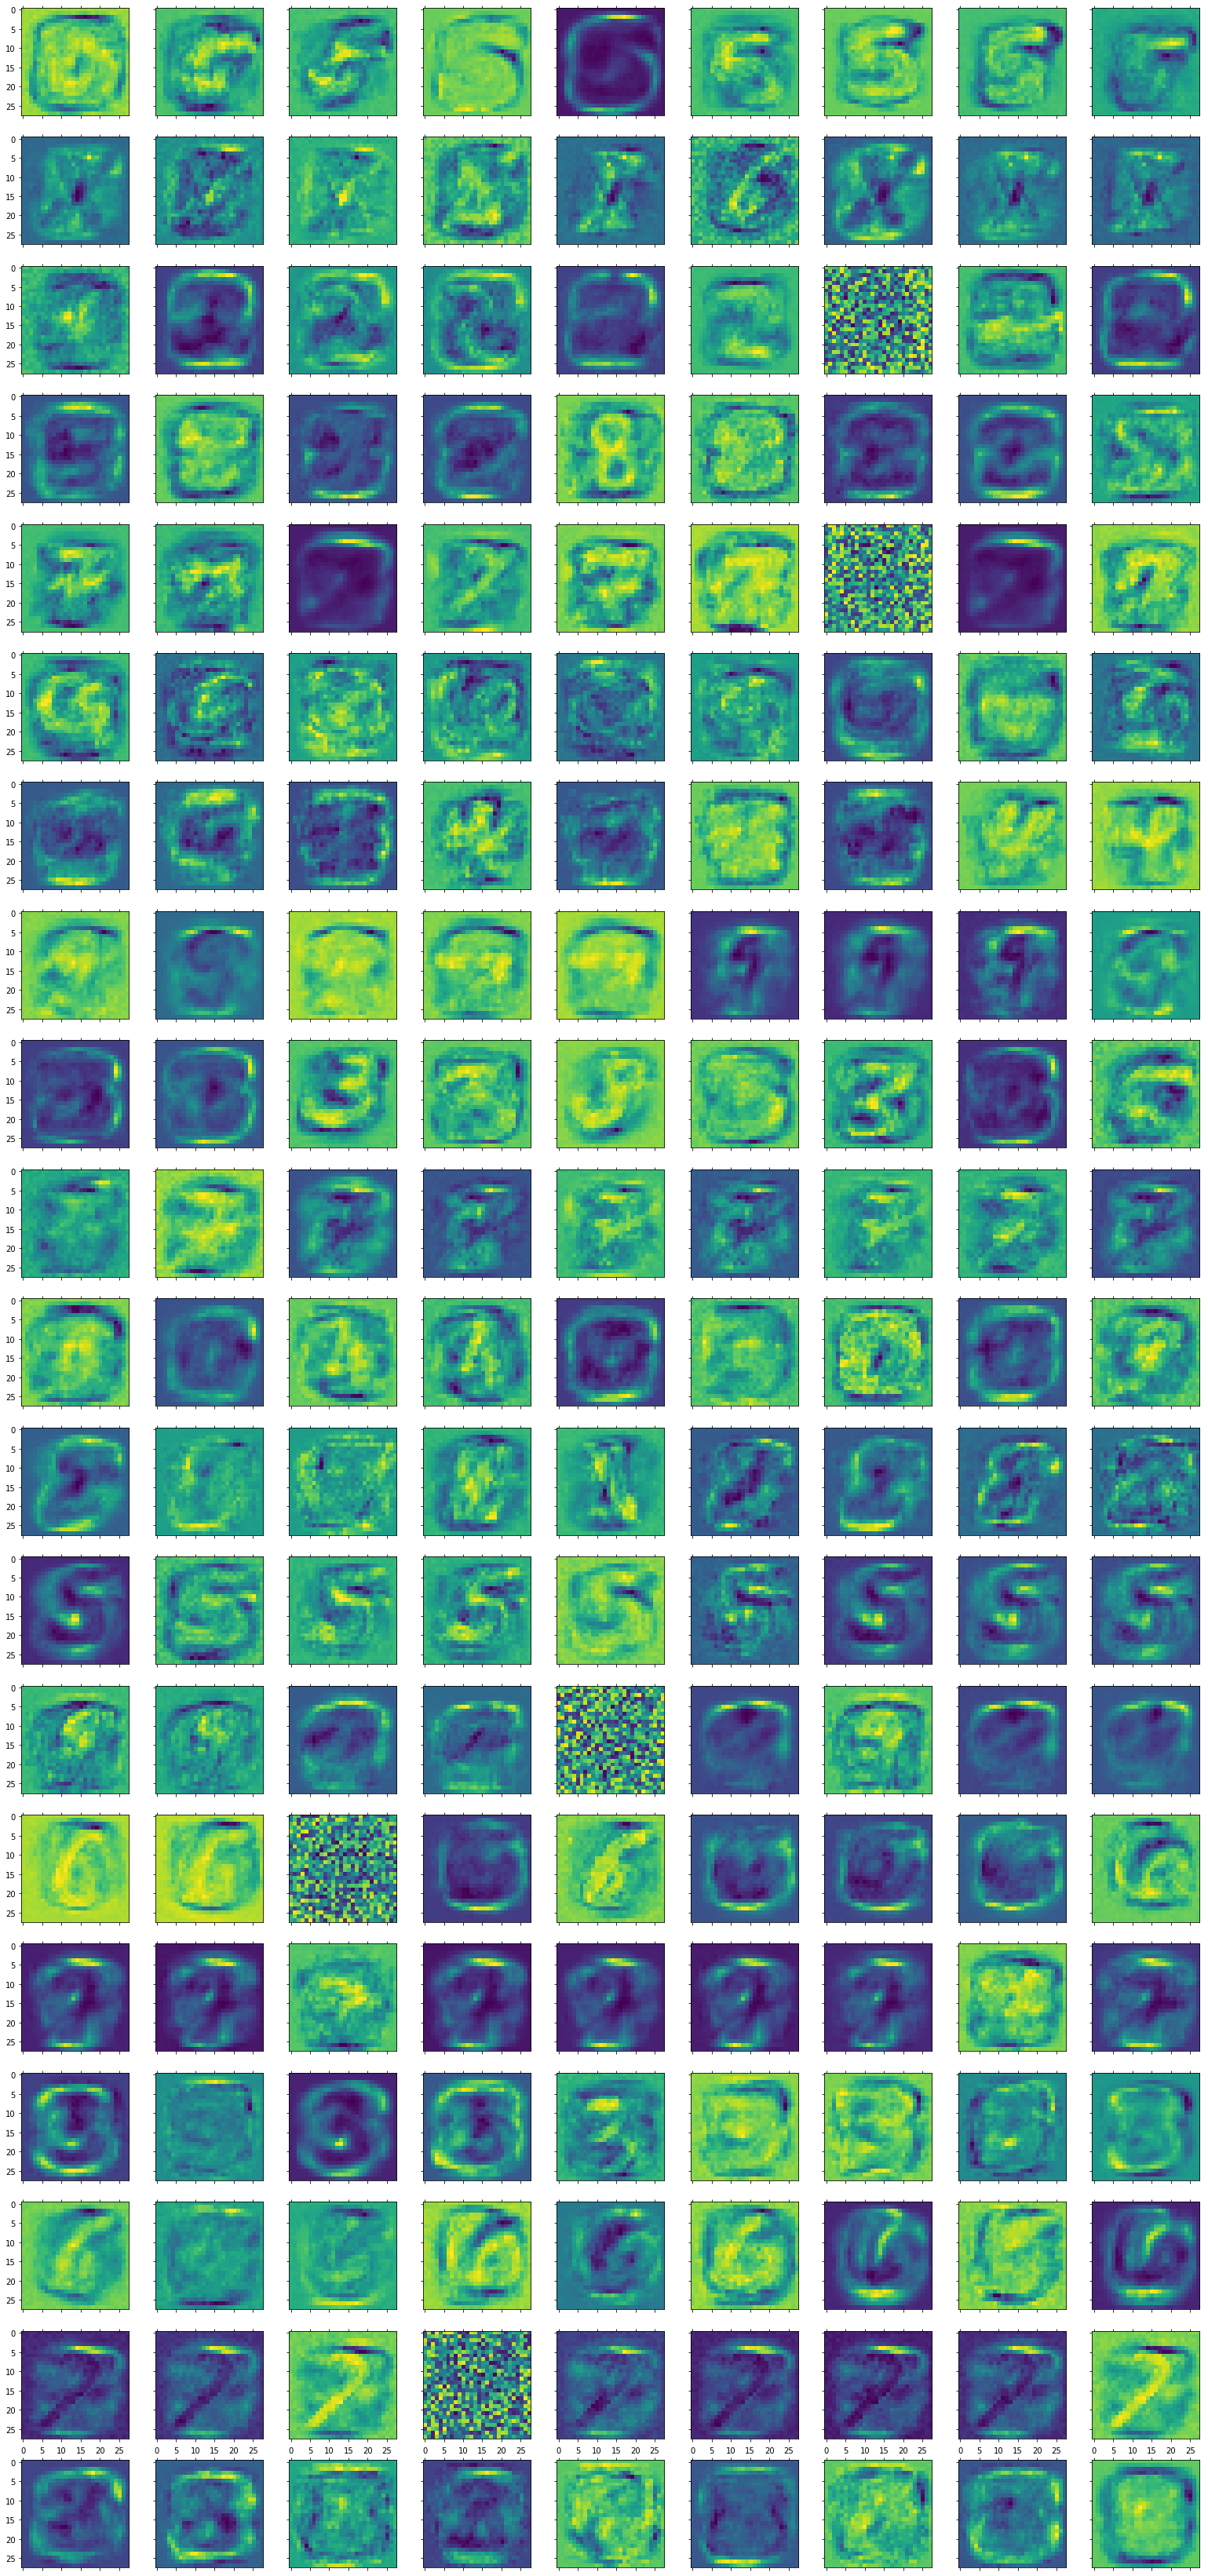

In [45]:
w = MODULE_SIZE
h = N_MODULES

f, a = plt.subplots(h, w, sharex=True, sharey=True, figsize=(w*3, h*3))

for i in range(N_MODULES):
    for j in range(MODULE_SIZE):
        a[i,j].matshow(W[i, :, j].reshape(IMAGE_SHAPE))

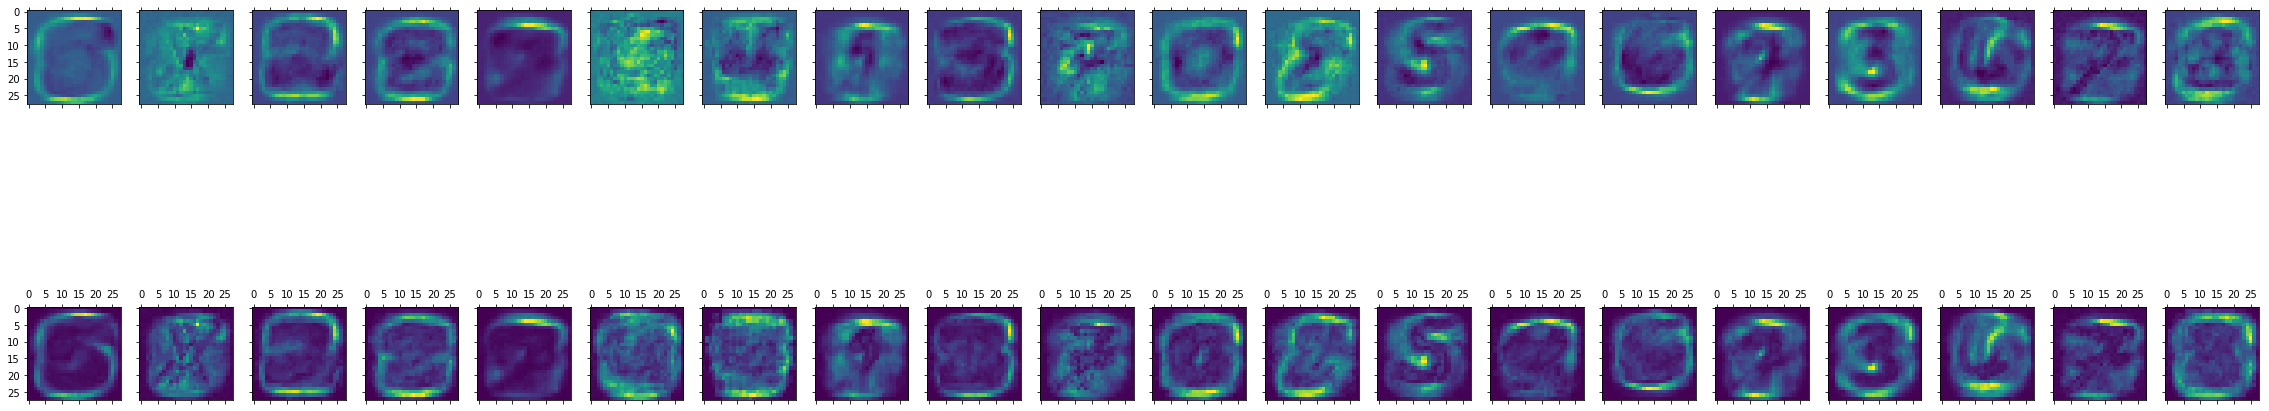

In [46]:
f, a = plt.subplots(2, N_MODULES, sharex=True, sharey=True, figsize=(40, 10))

for i in range(N_MODULES):
    a[0,i].matshow(np.mean(W[i], axis=1).reshape(IMAGE_SHAPE))
    a[1,i].matshow(np.std(W[i], axis=1).reshape(IMAGE_SHAPE))

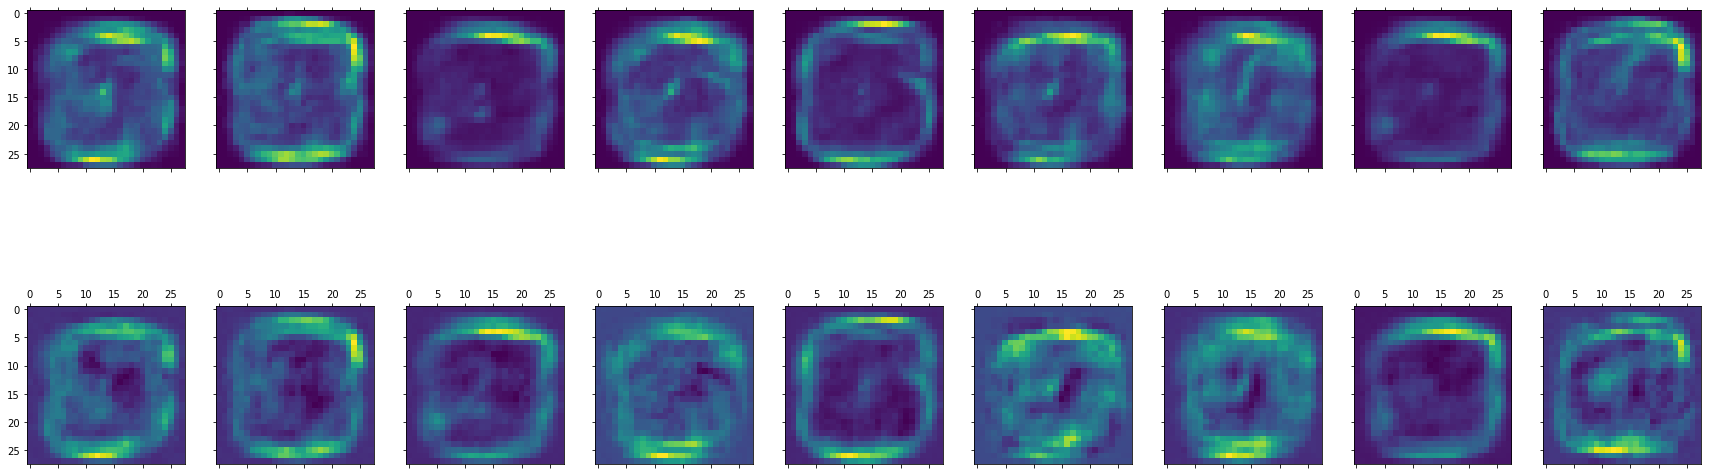

In [47]:
f, a = plt.subplots(2, MODULE_SIZE, sharex=True, sharey=True, figsize=(30, 10))

for i in range(MODULE_SIZE):
    a[0, i].matshow(np.std(W[:,:,i], axis=0).reshape(IMAGE_SHAPE))
    a[1, i].matshow(np.mean(W[:,:,i], axis=0).reshape(IMAGE_SHAPE))

In [48]:
l_outs = np.stack(res[1:])

In [49]:
prod = [np.array([np.dot(i, j) for i, j in zip(l_outs[a], l_outs[b])]) for a, b in pairs]

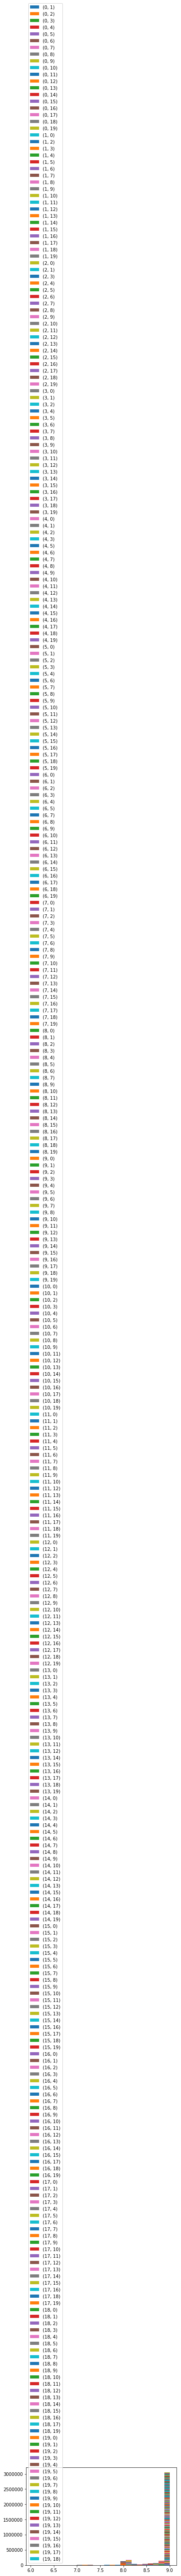

In [50]:
plt.hist(prod, bins=25, stacked=True, label=['{}'.format(i) for i in pairs])
plt.legend()
plt.show();

0


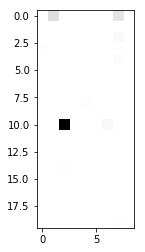

1


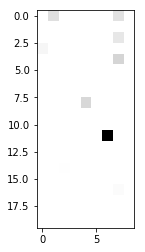

2


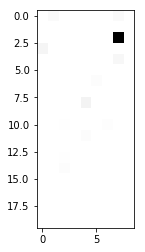

3


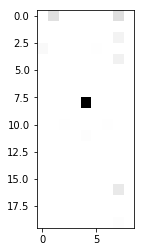

4


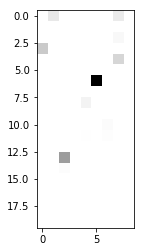

5


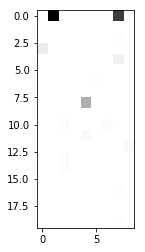

6


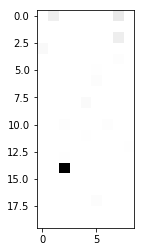

7


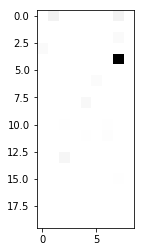

8


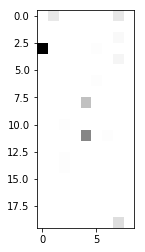

9


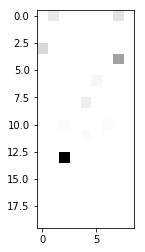

In [51]:
for i in range(10):
    slc = np.argwhere(y_test==i)[:, 0]
    print(i)
    plt.imshow(np.mean(l_outs[:,slc,:], axis=1)*255, cmap='gray')
    plt.show()

2
Label 3


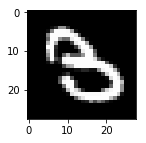

5
Label 4


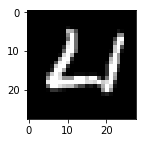

3
Label 1


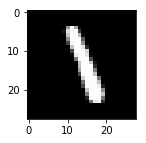

2
Label 6


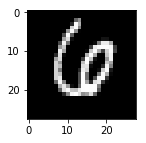

5
Label 9


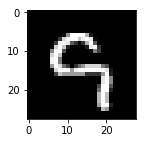

In [52]:
for i in np.argwhere(p != y_test)[:5,0]:
    print(p[i])
    printer(i, test=True)